In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Preprocessing

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


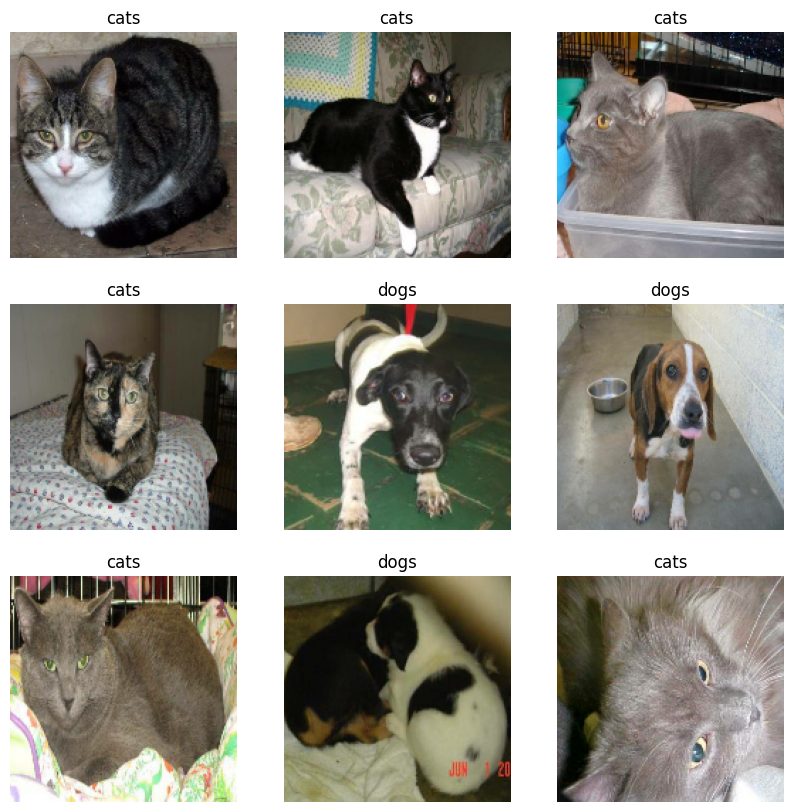

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
# 전체 데이터셋을 다시 두 부분으로 나누기
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Augmentation

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

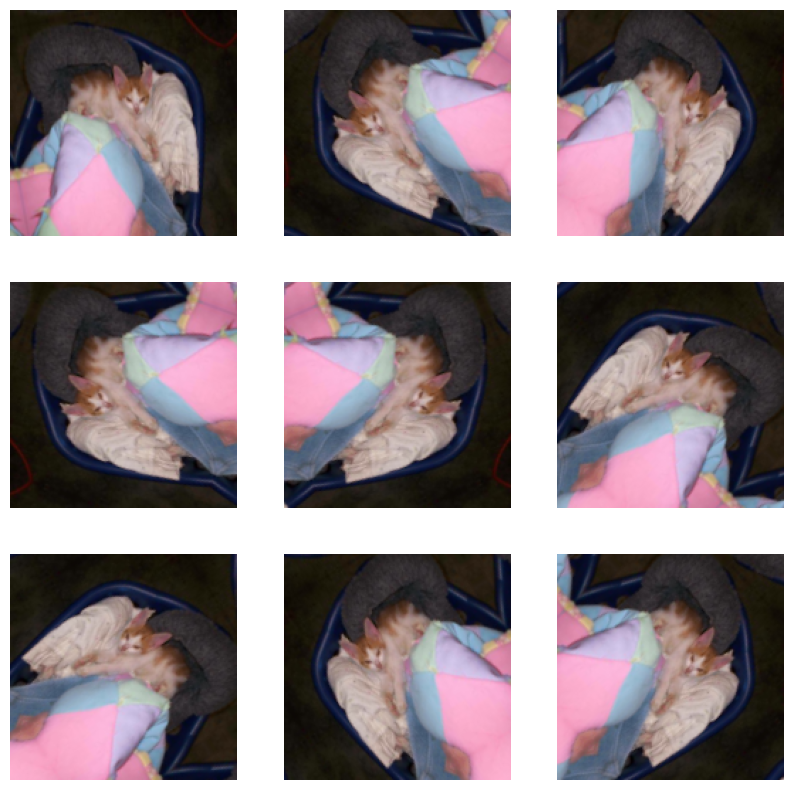

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Build a model

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# 입력 이미지의 픽셀 값을 [0, 255] 범위에서 [-1, 1] 범위로 변환
# 원래의 픽셀 값 [0, 255]가 [-1, 1]로 변환
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extract the features

In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## Add the classification on the top

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [21]:
len(model.trainable_variables)

2

## Training

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 39ms/step - loss: 0.9448 - accuracy: 0.4455


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.94
initial accuracy: 0.45


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 4s 47ms/step - loss: 0.7675 - accuracy: 0.5635 - val_loss: 0.6101 - val_accuracy: 0.6683
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 0.5582 - accuracy: 0.7045 - val_loss: 0.4453 - val_accuracy: 0.7785
Epoch 3/10
63/63 [==============================] - 2s 33ms/step - loss: 0.4606 - accuracy: 0.7790 - val_loss: 0.3448 - val_accuracy: 0.8478
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3860 - accuracy: 0.8145 - val_loss: 0.2787 - val_accuracy: 0.8960
Epoch 5/10
63/63 [==============================] - 2s 32ms/step - loss: 0.3270 - accuracy: 0.8500 - val_loss: 0.2317 - val_accuracy: 0.9196
Epoch 6/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3126 - accuracy: 0.8560 - val_loss: 0.1994 - val_accuracy: 0.9245
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 0.2739 - accuracy: 0.8795 - val_loss: 0.1825 - val_accuracy: 0.9319
Epoch 8/10
63/63 [======

## Leanrning Curve

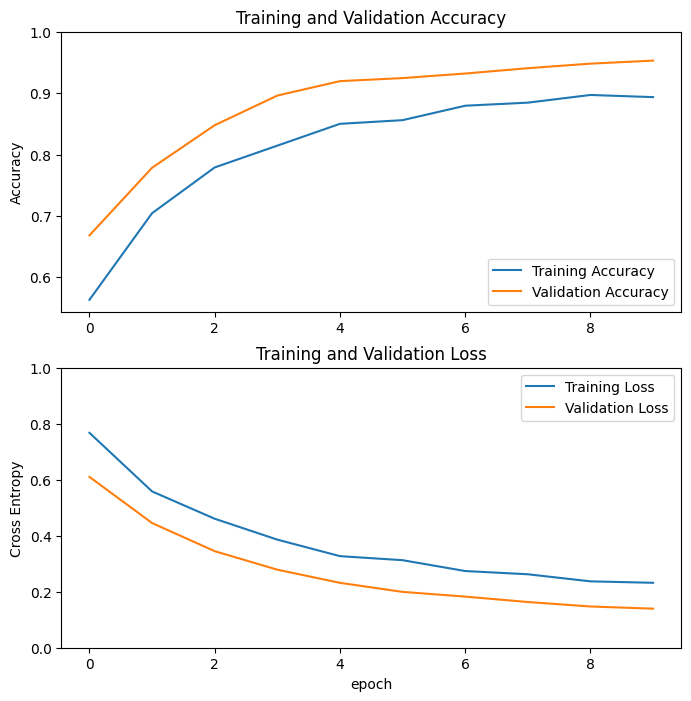

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 미세조정

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # base_model의 파라미터들을 학습 가능하도록 하고, 밑에서부터 N(=100)개의 레이어만 고정하도록 한다.

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Model Compile

In [28]:
# https://keras.io/api/optimizers/rmsprop/
# 복잡한 비선형 함수를 포함하는 딥 러닝 네트워크에서 뛰어난 성능
# 다른 최적화 알고리즘들에 비해 하이퍼파라미터 튜닝에 덜 민감
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
            metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

len(model.trainable_variables)

## Training the model

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 7s 54ms/step - loss: 0.1585 - accuracy: 0.9355 - val_loss: 0.0534 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 3s 45ms/step - loss: 0.1360 - accuracy: 0.9385 - val_loss: 0.0560 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 3s 44ms/step - loss: 0.1160 - accuracy: 0.9520 - val_loss: 0.0395 - val_accuracy: 0.9876
Epoch 13/20
63/63 [==============================] - 3s 45ms/step - loss: 0.0979 - accuracy: 0.9590 - val_loss: 0.0434 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 3s 43ms/step - loss: 0.0915 - accuracy: 0.9645 - val_loss: 0.0409 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 3s 48ms/step - loss: 0.0847 - accuracy: 0.9645 - val_loss: 0.0357 - val_accuracy: 0.9802
Epoch 16/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0793 - accuracy: 0.9675 - val_loss: 0.0446 - val_accuracy: 0.9790
Epoch 17/20
63/63 

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

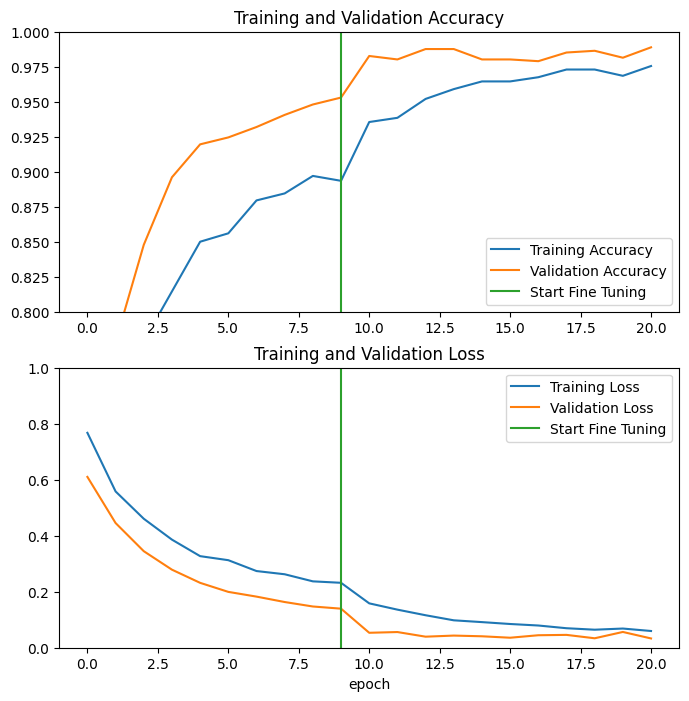

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 평가 및 예측

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 22ms/step - loss: 0.0570 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0]
Labels:
 [1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0]


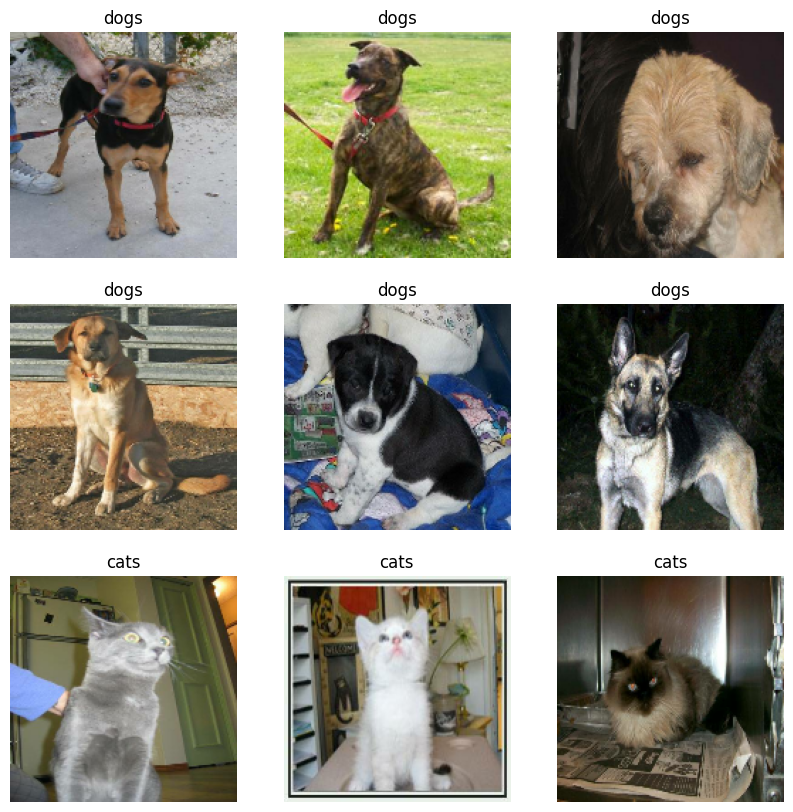

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# 오차행렬, 분류리포트, ROC커브곡선

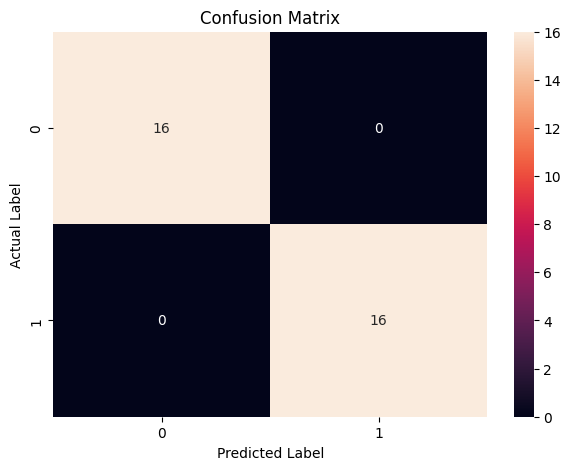

In [50]:
# 오차행렬
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(label_batch, predictions)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [47]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predictions))
"""
Precision: TP/(TP+FP)로, 모델이 참이라고 분류한 것 중에서 실제로 참인 비율을 나타냅니다.
Recall: TP/(TP+FN)로, 실제로 참인 것 중에서 모델이 참이라고 분류한 비율을 나타냅니다.
F1-score: Precision과 Recall의 조화평균으로, 두 메트릭의 균형을 나타냅니다.
"""

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



'\nPrecision: TP/(TP+FP)로, 모델이 참이라고 분류한 것 중에서 실제로 참인 비율을 나타냅니다.\nRecall: TP/(TP+FN)로, 실제로 참인 것 중에서 모델이 참이라고 분류한 비율을 나타냅니다.\nF1-score: Precision과 Recall의 조화평균으로, 두 메트릭의 균형을 나타냅니다.\n'

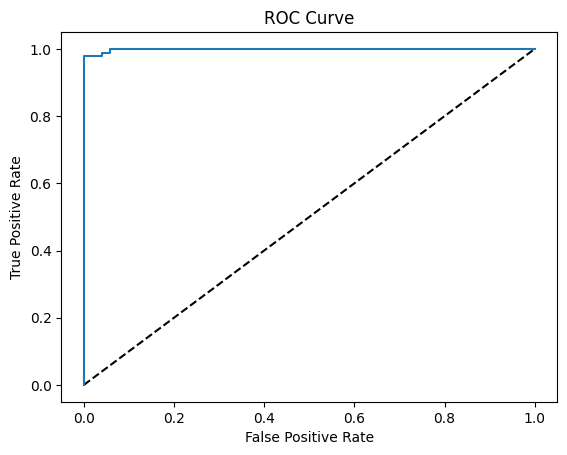

AUC:  0.9989106753812635


In [43]:
# ROC 커브곡선
from sklearn.metrics import roc_curve, roc_auc_score

test_images = []
test_labels = []

# Extract images and labels from the test_dataset
for image, label in test_dataset:
    test_images.append(image)
    test_labels.append(label)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Generate predictions
y_pred_prob = model.predict(test_images)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC score
print('AUC: ', roc_auc_score(test_labels, y_pred_prob))

In [44]:
model.save('my_puppy.h5')